# Demo notebook for the [ridge directed ring detector](https://github.com/eldad-a/ridge-directed-ring-detector)

## <a id='Table of contents'></a> Table of contents

1. [Reproduce demo in the manuscript](#channel_demo)
2. [Reproduce the example from scikit-image using the ridge-directed-ring-detector](#skimage)
3. TODO...

#### Dependencies:
2. Cython
1. Scipy
3. OpenCV (for fast array derivatives, can be replaced by `scipy.ndimage`, and for the EllipseFit which should rarely of real need)

For this notebook:
* pandas (for table pretty printing)
* Scikit-Image (for the comparison)

Your comments are welcome. 

Acknowledgements would be highly appreciated; for academic citation please use E. Afik, [Robust and highly performant ring detection algorithm for 3d particle tracking using 2d microscope imaging](http://www.nature.com/articles/srep13584). Sci. Rep. 5, 13584; doi: 10.1038/srep13584 (2015).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
##  load (and compile if necessary) the ridge_directed_ring_detector
# import pyximport; pyximport.install()
# import ridge_directed_ring_detector as ring_detector
from skimage.transform import _ring_detector as ring_detector

In [10]:
# ring_detector.__file__

In [11]:
## a function to plot the rings
pi = np.pi

colourmap = plt.jet
txt_colour = 'r'
ring_colour = 'y'

def plot_rings(xyr, minrad=1, ring_colour = 'g', ring_style=[None,'dotted','dashed'][0], lw=1, txt_colour='b', title=None):
    '''
    given a 3-column array of (x,y) for ring centres & a radius, plots the
    rings
    '''
    #import matplotlib.pyplot as plt
    for c in xyr:
        if c[-1]>minrad:
            circ = plt.Circle(c[:2][::-1],c[-1],ec=ring_colour,fill=False, lw=lw, ls=ring_style) 
            plt.gca().add_patch(circ)
            i,j,r = c
            if txt_colour:
                plt.text(j,i,'.', fontsize=20, color=txt_colour)
    plt.draw()

## <a id='channel_demo'></a>  Reproduce demo in the [manuscript](http://www.nature.com/articles/srep13584)

In [12]:
ridge_hough = ring_detector.RidgeHoughTransform()

default_params = ridge_hough.params.copy()

ridge_hough.params['sigma'] = 0.8
ridge_hough.params['curv_thresh'] = -50
ridge_hough.params['circle_thresh'] = 2 * np.pi * .33
ridge_hough.params['Rmin'] = 4
ridge_hough.params['Rmax'] = 50
ridge_hough.params['vote_thresh'] = 4
ridge_hough.params['dr'] = 3
ridge_hough.params['eccentricity'] = 0
experimental_params = ridge_hough.params.copy()

# print 'default img analysis parameters:'
# for key in sorted(default_params.keys()):
#     print '\t %s = %s'  % (key, default_params[key])
    
print( '\nimg analysis parameters in the experiment:')
for key in sorted(experimental_params.keys()):
    print( '\t %s = %s'  % (key, experimental_params[key]))


img analysis parameters in the experiment:
	 Rmax = 50
	 Rmin = 4
	 circle_thresh = 2.0734511513692637
	 curv_thresh = -50
	 dr = 3
	 eccentricity = 0
	 ksize = 5
	 sigma = 0.8
	 vote_thresh = 4


In [13]:
## Load picture
imgName = './unprocessed_fig_46.png'
img = plt.imread(imgName )

if img.max()<=1.:
    img*=255./img.max()
    
IMG = img.astype(np.float32)

In [15]:
%%time

ridge_hough = ring_detector.RidgeHoughTransform(IMG)
ridge_hough.img_preprocess()
#ridge_hough.debugging_rings_detection()
ridge_hough.rings_detection()
#detected_rings = ridge_hough.output['rings']
rings = ridge_hough.output['rings_subpxl'] # keep for later (sub-pxl mask example)

print( 'NB: first run may be several times slower and not indicative.\n')

NB: first run may be several times slower and not indicative.

CPU times: user 454 ms, sys: 31.8 ms, total: 486 ms
Wall time: 496 ms


found 58 rings


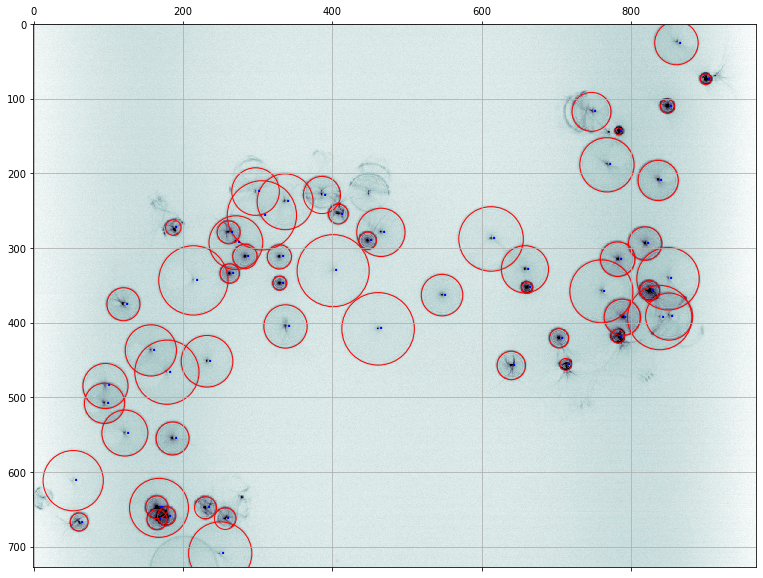

In [17]:
fig,ax = plt.subplots(figsize=(15,10))
im = ax.matshow(IMG, cmap=plt.cm.bone_r, vmax=80)
# fig.colorbar(im)
plot_rings(rings, ring_colour='r')
plt.grid(True)
print( 'found {} rings'.format(rings.shape[0]))

In [20]:
if True:
    import pandas as pd
    #pd.set_option('display.max_rows', 10)
    rings_df = pd.DataFrame(rings[rings.T[-1].argsort()[::-1]], 
                            columns=['row','col','rad'], 
                            index=range(1,rings.shape[0]+1),
                            )
rings_df

,row,col,rad
1,408.176910,461.251709,48.545418
2,330.256012,401.067688,48.238937
3,343.312378,213.903900,46.409515
4,256.172424,305.647461,46.350906
5,287.775879,612.518372,43.204762
6,393.092865,838.347351,43.097740
7,466.228119,178.406967,42.978962
8,708.943970,249.834793,42.313602
9,357.993530,760.224548,42.171597
10,341.070374,849.519592,41.789619


Least principal eigenvalue of the Hessian takes roughly 4% of the execusion time, therefore

optimisation attempts should focus on the steps following the Least principal curvature calculation

In [21]:
%%timeit
ridge_hough = ring_detector.RidgeHoughTransform(IMG)
ridge_hough.img_preprocess()
# ridge_hough.debugging_rings_detection()
# ridge_hough.rings_detection()
# # detected_rings = ridge_hough.output['rings']
# rings = ridge_hough.output['rings_subpxl'] # keep for later (sub-pxl mask example)

7.39 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## <a id='skimage'></a>  Reproduce the [example from scikit-image](http://scikit-image.org/docs/dev/auto_examples/plot_circular_elliptical_hough_transform.html#circular-and-elliptical-hough-transforms)  using the [ridge directed ring detector](http://www.nature.com/articles/srep13584)

In [22]:
from skimage import data
from scipy import ndimage, misc

In [23]:
image = data.coins()[0:95, 70:370]

In [24]:
%%time

## as the algorithm is currently meant for ridges, convert the image to a gradient magnitude image
IMG = image.astype(np.float32)
sigma = .5
d_mag = ndimage.gaussian_gradient_magnitude(IMG, sigma)

IMG = d_mag

ridge_hough = ring_detector.RidgeHoughTransform(IMG)
ridge_hough.params['sigma'] = 3
ridge_hough.params['Rmin'] = 15
ridge_hough.params['Rmax'] = 30
ridge_hough.params['curv_thresh'] = -35
ridge_hough.params['circle_thresh'] = .4*2*pi
ridge_hough.params['vote_thresh'] = 3
ridge_hough.params['dr'] = 3
ridge_hough.img_preprocess()
#ridge_hough.debugging_rings_detection()
ridge_hough.rings_detection()
#detected_rings = ridge_hough.output['rings']
CHT_rings = ridge_hough.output['rings_subpxl'] # keep for later (sub-pxl mask example)

print( 'NB: first run may be several times slower and not indicative.\n')

NB: first run may be several times slower and not indicative.

CPU times: user 60.8 ms, sys: 3.74 ms, total: 64.6 ms
Wall time: 64.2 ms


[[ 52.335308 206.22508   18.849789]
 [ 56.561295  30.303745  18.23407 ]
 [ 50.786148  85.13285   22.399513]
 [ 50.84338  145.3604    22.254793]
 [ 43.767956 264.86792   27.961924]]


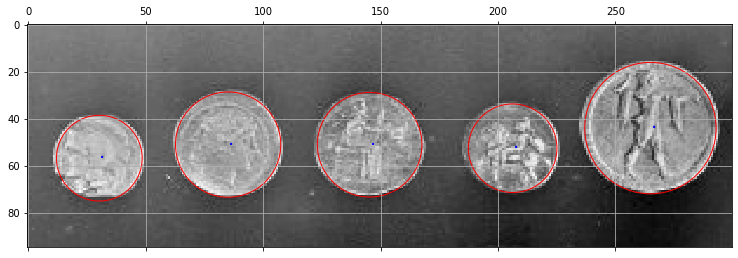

In [25]:
plt.matshow(image, cmap=plt.cm.gray)
plot_rings(CHT_rings, ring_colour='r')
plt.grid(True)
print( CHT_rings)

**NB** this algorithm does not rely on the user specifying how many circles are in the image

### Intermediate stages:

#### show the gradient magnitude field

gradient magnitude: 
	mean = 6.951609134674072 
	std = 11.113326072692871


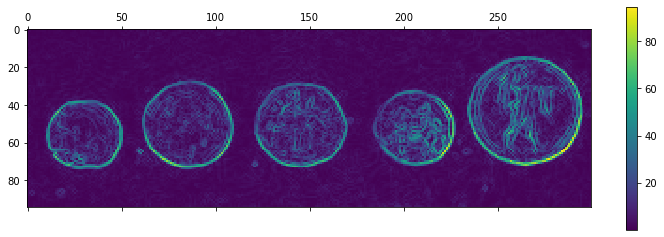

In [26]:
if False:
    image = data.coins()[0:95, 70:370].astype(np.float32)
    sigma = .5
    di,dj = [ndimage.gaussian_filter(image,sigma,order=der) for der in ((0,1),(1,0))]
    d_mag = np.sqrt(di**2+dj**2)
    
plt.matshow(d_mag)
plt.colorbar()
print( 'gradient magnitude: \n\tmean = {} \n\tstd = {}'.format(d_mag.mean(), d_mag.std()))

#### show the least principal curvature field

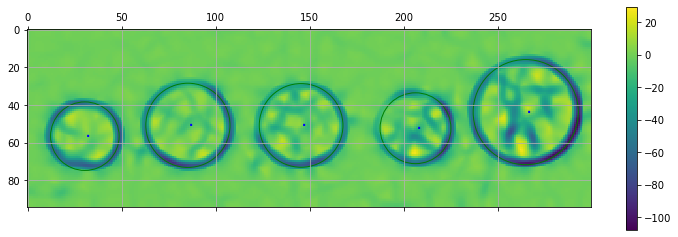

In [27]:
plt.matshow(np.asarray(ridge_hough.deriv['principal_curv']))
plt.colorbar()
#A = [plot(circ[1],circ[0],'o') for circ in CHT_rings]
plot_rings(CHT_rings)
plt.grid(True)
#print CHT_rings

## Demo TODO

+ add an interactive demo of the result due to parameters modification
+ add code to reproduce the figures in the manuscript